In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from math import exp, log10
sns.set()
# Scipy Optimization Algorithm is used to find the optimal parameters
import scipy.optimize as opt
# Scipy is needed to load a MATLAB digit dataset
from scipy.io import loadmat
from IPython.display import Image, display

In [9]:
data = loadmat('ex3data1')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [10]:
dataX = pd.DataFrame.from_dict(data['X'])
dataX.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
datay = pd.DataFrame.from_dict(data['y'])
datay.head()

,0
0,10
1,10
2,10
3,10
4,10


In [12]:
pd.unique(datay[0]) # the '0' is shown as '10' 

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [13]:
# replace the 10 on 0
datay[0][datay[0]==10] = 0

In [14]:
pd.unique(datay[0])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [15]:
# Construct the X any Y matrix arrays
X = np.array(dataX)
#Add ones to the X matrix
X=np.column_stack((np.ones(len(X)),X))

Y = np.array(datay[0])
print('X (feature) matrix shape is ', X.shape)
print('Y matrix shape is ', Y.shape)

X (feature) matrix shape is  (5000, 401)
Y matrix shape is  (5000,)


In [16]:
# Cost Function for Regularization
LearningRate=0
l = len(Y)
def cost_reg(T,X,Y,LearningRate):
    k=np.matmul(X,T)
    g=1/(1+np.exp(-k))
    c = (np.multiply(-Y,np.log(g)) - np.multiply((1-Y),np.log(1-g)))
    c=(c.sum())/l
    
    #Regularization parameter
    c_reg=(T**2).sum()
    c_reg=c_reg*(LearningRate/(2*len(Y)))
    
    cost_regul = c+c_reg
    return (cost_regul) 

In [17]:
#Gradient Function, with Regularization
def grad_reg(T,X,Y,LearningRate):
    k=np.matmul(X,T)
    g=1/(1+np.exp(-k))
    error = g-Y
    g = np.matmul(error,X)/(len(Y))
    
    #Regularization part
    g_reg=LearningRate/len(Y)*(T)
    g_reg[0]=0
    
    grad_regul = g + g_reg
    return grad_regul

In [18]:
# Look also at alternative way of constructing One_vs_All (one_vs_zero) matrix

def get_theta(X,Y):
    T=np.zeros(len(X[0,:]))
    for i in range (10):
        
        # Construct a Y array for the digit (i). 
        y_int=Y
        y_int=(y_int==i)  #result is True False Array
        y_int = y_int.astype(int) # convert to 0 1 array
        
        #Alternative way of constructing One_vs_All (one_vs_zero) matrix
        #y_int = np.array([1 if label == i else 0 for label in Y])
        
        # Optimization and Theta calculation
        t = np.zeros(len(X[0,:]))
        theta, theta_i = opt.fmin_bfgs(cost_reg,x0=t,fprime=grad_reg,args=(X, y_int, LearningRate),retall = 1, disp = 0)
        T = np.column_stack((T,theta))
    
    #Drop the first column with zeros and return a Theta matrix
    return T[:,1:]      

T=get_theta(X,Y)

####                                                  How is it looks like? The (T) matrix is shown below

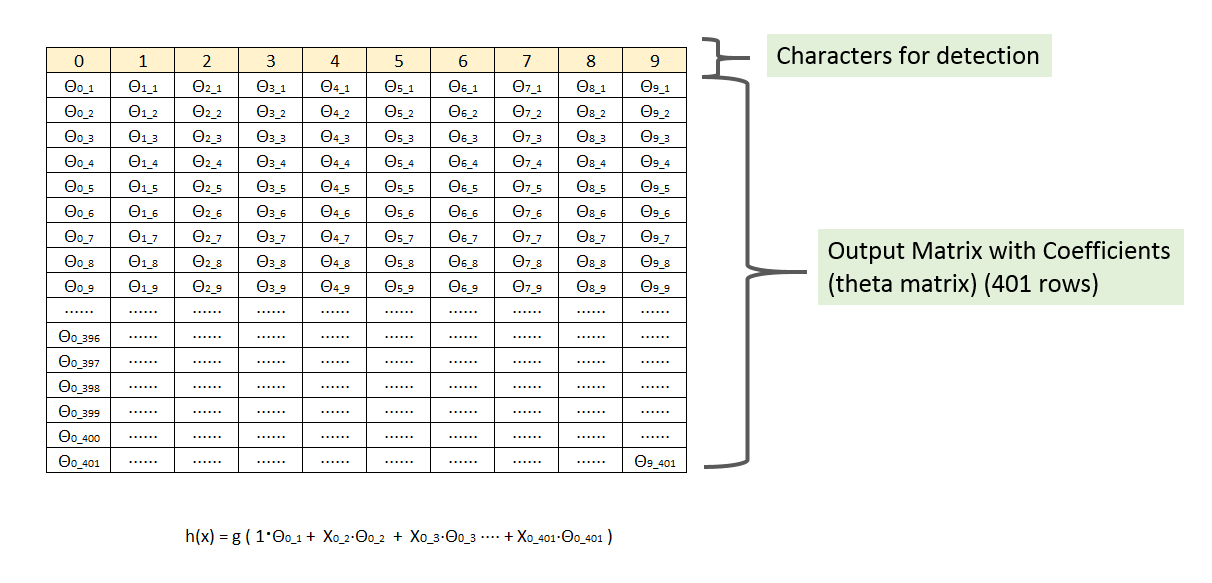

In [19]:
display(Image(filename='mult_log2.PNG', embed=True, width=900))

In [20]:
print('Dimension of Theta matrix: ',T.shape)

Dimension of Theta matrix:  (401, 10)


### Next we need to check an accuracy of our model 

In [21]:
# Firstly lets construct The Sigmoid Function g(x). Note that we need to find a max a probability in the received Y_matrix
# among the all digits. The Sigmoid is our probability

def g(X,T):
    y = np.matmul(X,T)
    y = 1/(1+np.exp(-y))
    return y
g(X,T).shape    

(5000, 10)

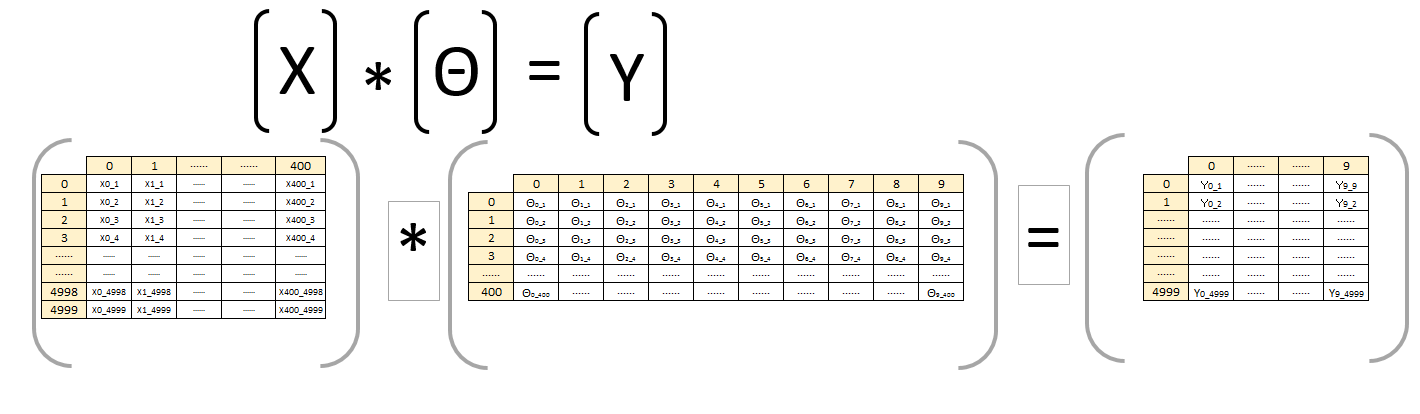

In [22]:
display(Image(filename='mult_log4.PNG', embed=True, width=1000))

  ### The Function we will use is: 
  #### numpy.argmax(a, axis=None, out=None)
 
    Returns the indices of the maximum values along an axis.  
    Parameters:	    
    a : array_like   
        Input array.        
    axis : int, optional    
        By default, the index is into the flattened array, otherwise along the specified axis.        
    out : array, optional    
        If provided, the result will be inserted into this array. It should be of the appropriate shape and dtype.        
    Returns:    
    index_array : ndarray of ints    
        Array of indices into the array. It has the same shape as a.shape with the dimension along axis removed.

In [23]:
def accuracy(t,X,Y):
    f = g(X,t)
    f=np.argmax(f, axis=1)
    f =(f==Y)  #result is True False Array
    f = f.astype(int) # convert ro 0 1 array
    
    accur=f.sum()/len(Y)
    return accur

In [24]:
print ('Accuracy of prediction is ',accuracy(T,X,Y))

Accuracy of prediction is  0.9732
